In [30]:
import requests
import json

# All sensor_ids you want to query
sensor_ids = [
    "20578001", "20578002", "20578003", "20578004", "20578005", "20578006", "20578007", "20578008", "20578009", "20578010", 
    # ... (other sensor IDs)
]

# Your API base URL
base_url = 'https://uclapi.com/workspaces/historical/data?survey_id=8&datetime__lte=2022-07-09T14%3A00%3A00&datetime__gte=2022-06-18T14%3A00%3A00&token=uclapi-f14c455679d6f8f-8fbfd61b137ba27-8a96d3c8a026f95-e5d621f791d6d53'

# Store all data
all_data = {}

# Request data for each sensor_id
for id in sensor_ids:
    url = base_url + '&sensor_id=' + id
    response = requests.get(url)
    data = response.json()
    all_data[id] = data

# Print all data, or you can process this data as needed
print(json.dumps(all_data, indent=4))

# Save data to a JSON file
with open('alldata_lastyear.json', 'w') as f:
    json.dump(all_data, f, indent=4)


{
    "20578001": {
        "okay": true,
        "data": {
            "next": null,
            "previous": null,
            "results": [
                {
                    "sensor_id": 20578001,
                    "datetime": "2022-06-18T14:50:00",
                    "state": 0
                },
                {
                    "sensor_id": 20578001,
                    "datetime": "2022-06-18T15:00:00",
                    "state": 1
                },
                {
                    "sensor_id": 20578001,
                    "datetime": "2022-06-18T15:10:00",
                    "state": 0
                },
                {
                    "sensor_id": 20578001,
                    "datetime": "2022-06-18T15:20:00",
                    "state": 1
                },
                {
                    "sensor_id": 20578001,
                    "datetime": "2022-06-18T15:40:00",
                    "state": 0
                },
                {
           

In [31]:
import pandas as pd
import json

# Load JSON data
with open('alldata_lastyear.json', 'r') as f:
    data = json.load(f)

# Extract and flatten the data
data_list = []
for sensor_id, sensor_data in data.items():
    for result in sensor_data['data']['results']:
        data_list.append({
            'sensor_id': sensor_id,
            'datetime': result['datetime'],
            'state': result['state']
        })

# Convert to a DataFrame
df = pd.DataFrame(data_list)

# Write to a CSV file
df.to_csv('alldata_0807_lastyear.csv', index=False)


In [32]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("alldata_0807_lastyear.csv")

# Remove rows with state equal to -1
data = data[data['state'] != -1]

# Convert the 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Get the time part
data['time'] = data['datetime'].dt.time

# Define work time range
work_start_time = pd.to_datetime("09:00:00").time()
work_end_time = pd.to_datetime("20:00:00").time()

# For non-work hours, change state values from 1 to 0
data.loc[(data['time'] < work_start_time) & (data['state'] == 1), 'state'] = 0
data.loc[(data['time'] > work_end_time) & (data['state'] == 1), 'state'] = 0

# Define date ranges to keep and remove
start_date = pd.to_datetime("2022-06-01")
end_date = pd.to_datetime("2022-07-30")
remove_start = pd.to_datetime("2022-07-31")
remove_end = pd.to_datetime("2022-08-06")

# Filter data based on date ranges
data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
data = data[~((data['datetime'] >= remove_start) & (data['datetime'] <= remove_end))]

# Drop the temporary 'time' column
data = data.drop(columns=['time'])

# Save the cleaned data to a new CSV file
data.to_csv("cleaned_data_lastyear.csv", index=False)




In [33]:
import pandas as pd

# Read the data
sensor_room_df = pd.read_csv('../hourtimeseries/unique_sensor_ids_edit.csv')
counts_df = pd.read_csv('cleaned_data_lastyear.csv')

# Merge the dataframes based on the 'sensor_id' column
merged_df = pd.merge(counts_df, sensor_room_df, on='sensor_id')

# Save the new dataframe to a CSV file
merged_df.to_csv('merged0807_lastyear.csv', index=False)


In [34]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('merged0807_lastyear.csv')

# Convert the datetime column to pandas datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Create a new column that only keeps the hour information
df['hour'] = df['datetime'].dt.floor('H')

# Group the data by sensor_id, room, and hour, and count occurrences where state is 1
result = df[df['state'] == 1].groupby(['sensor_id', 'room', 'hour']).size().reset_index(name='count_1s')

# Save the result to a new CSV file
result.to_csv('hourly_counts_lastyear.csv', index=False)





In [35]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('merged0807_lastyear.csv')

# Convert the datetime column to pandas datetime type and create an 'hour' column
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.floor('H')

# Group the data by sensor_id, room, and hour, and count occurrences where state is 1
result = df[df['state'] == 1].groupby(['sensor_id', 'room', 'hour']).size().reset_index(name='count_1s')

# Create the date range
date_range = pd.date_range(start='2022-06-18 00:00:00', end='2022-07-09 23:00:00', freq='H')

# Get unique sensor_id and room combinations
unique_sensors = df[['sensor_id', 'room']].drop_duplicates()

# Use cross join to create a complete date range for each sensor_id
unique_sensors['key'] = 1
date_df = pd.DataFrame({'hour': date_range})
date_df['key'] = 1

full_df = pd.merge(unique_sensors, date_df, on='key').drop('key', axis=1)

# Merge full_df with result using merge method, and fill missing values with 0 using fillna
final_result = pd.merge(full_df, result, on=['sensor_id', 'room', 'hour'], how='left').fillna(0)
final_result['count_1s'] = final_result['count_1s'].astype(int)

# Save the final result to a new CSV file
final_result.to_csv('final_hourly_counts_lastyear.csv', index=False)



In [36]:
import pandas as pd

# Read the file
df = pd.read_csv('final_hourly_counts_lastyear.csv')

# Convert the 'hour' column to datetime format
df['hour'] = pd.to_datetime(df['hour'])

# Group by 'room' and 'hour', and calculate the total sum of 'count_1s'
df_grouped = df.groupby(['room', 'hour'])['count_1s'].sum().reset_index()

# Save the result to a new CSV file
df_grouped.to_csv('grouped_hourly_counts_lastyear.csv', index=False)



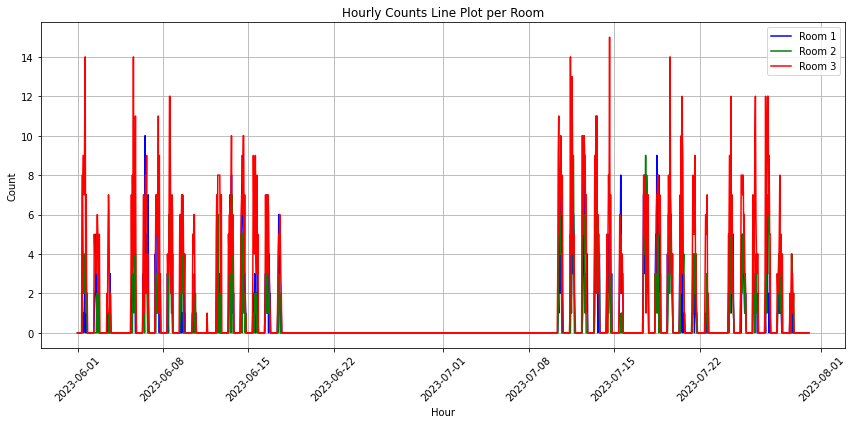

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the file
df = pd.read_csv('grouped_hourly_counts.csv')

# Convert the 'hour' column to datetime format
df['hour'] = pd.to_datetime(df['hour'])

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot for each room
rooms = df['room'].unique()
colors = ['blue', 'green', 'red']  # Set colors, assuming you have only 3 rooms. If more, add more colors.

for idx, room in enumerate(rooms):
    room_df = df[df['room'] == room]
    plt.plot(room_df['hour'], room_df['count_1s'], color=colors[idx], label=f'Room {room}')

plt.title('Hourly Counts Line Plot per Room')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Optimize layout
plt.legend()
plt.grid(True)
plt.show()



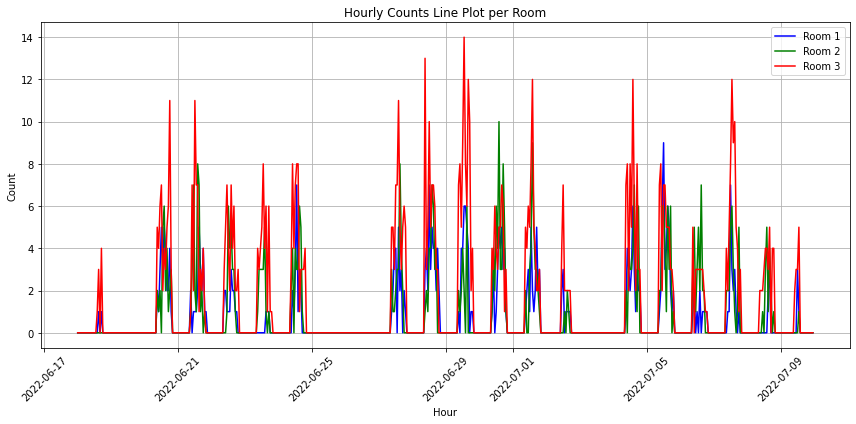

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the file
df = pd.read_csv('grouped_hourly_counts_lastyear.csv')

# Convert the 'hour' column to datetime format
df['hour'] = pd.to_datetime(df['hour'])

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot for each room
rooms = df['room'].unique()
colors = ['blue', 'green', 'red']  # Set colors, assuming you have only 3 rooms. If more, add more colors.

for idx, room in enumerate(rooms):
    room_df = df[df['room'] == room]
    plt.plot(room_df['hour'], room_df['count_1s'], color=colors[idx], label=f'Room {room}')

plt.title('Hourly Counts Line Plot per Room')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Optimize layout
plt.legend()
plt.grid(True)
plt.show()


In [38]:
print(df)

      room                hour  count_1s
0        1 2022-06-18 00:00:00         0
1        1 2022-06-18 01:00:00         0
2        1 2022-06-18 02:00:00         0
3        1 2022-06-18 03:00:00         0
4        1 2022-06-18 04:00:00         0
...    ...                 ...       ...
1579     3 2022-07-09 19:00:00         0
1580     3 2022-07-09 20:00:00         0
1581     3 2022-07-09 21:00:00         0
1582     3 2022-07-09 22:00:00         0
1583     3 2022-07-09 23:00:00         0

[1584 rows x 3 columns]


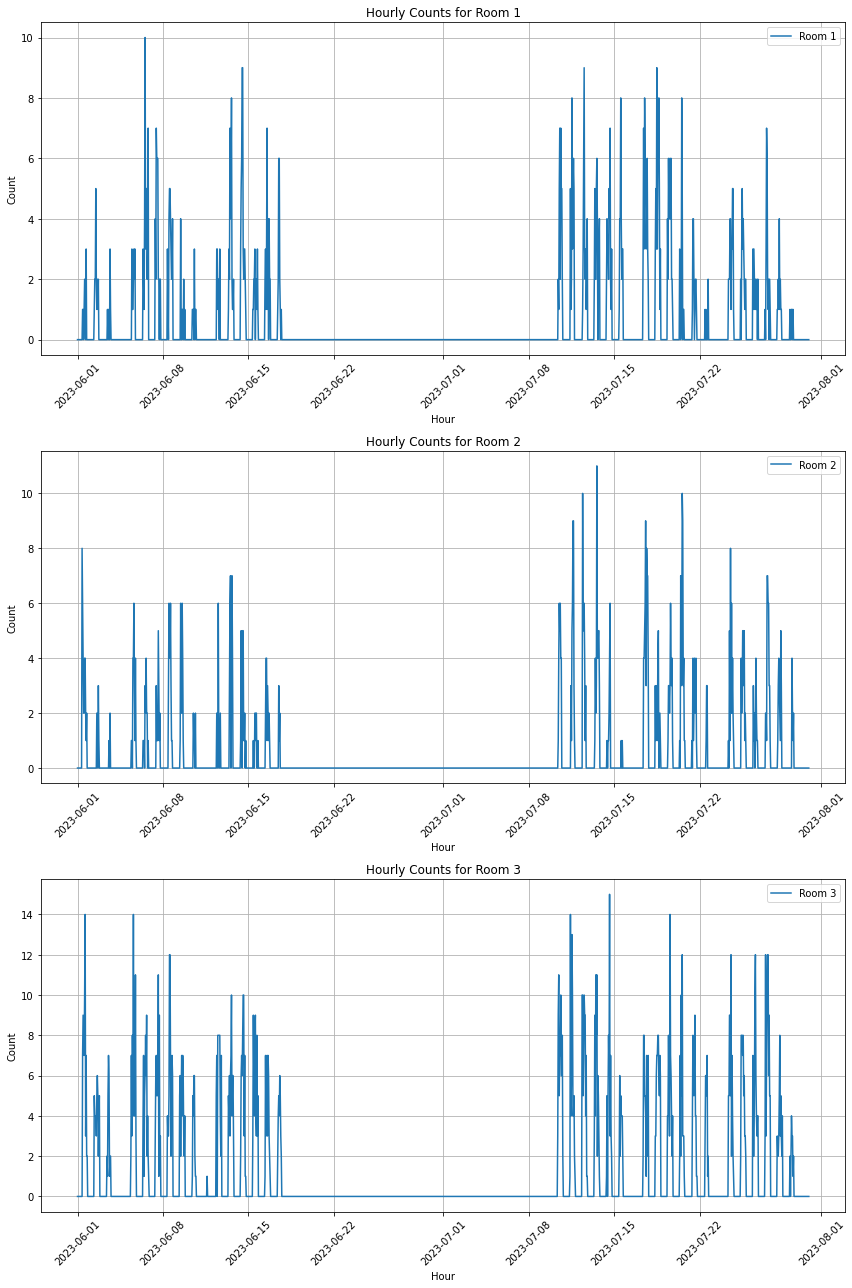

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the file
df = pd.read_csv('grouped_hourly_counts.csv')

# Convert the 'hour' column to datetime format
df['hour'] = pd.to_datetime(df['hour'])

# Get unique room count
rooms = df['room'].unique()

# Create multiple subplots
fig, axes = plt.subplots(nrows=len(rooms), figsize=(12, 6 * len(rooms)))

for idx, room in enumerate(rooms):
    room_df = df[df['room'] == room]
    axes[idx].plot(room_df['hour'], room_df['count_1s'], label=f'Room {room}')
    axes[idx].set_title(f'Hourly Counts for Room {room}')
    axes[idx].set_xlabel('Hour')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(True)
    axes[idx].legend()
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


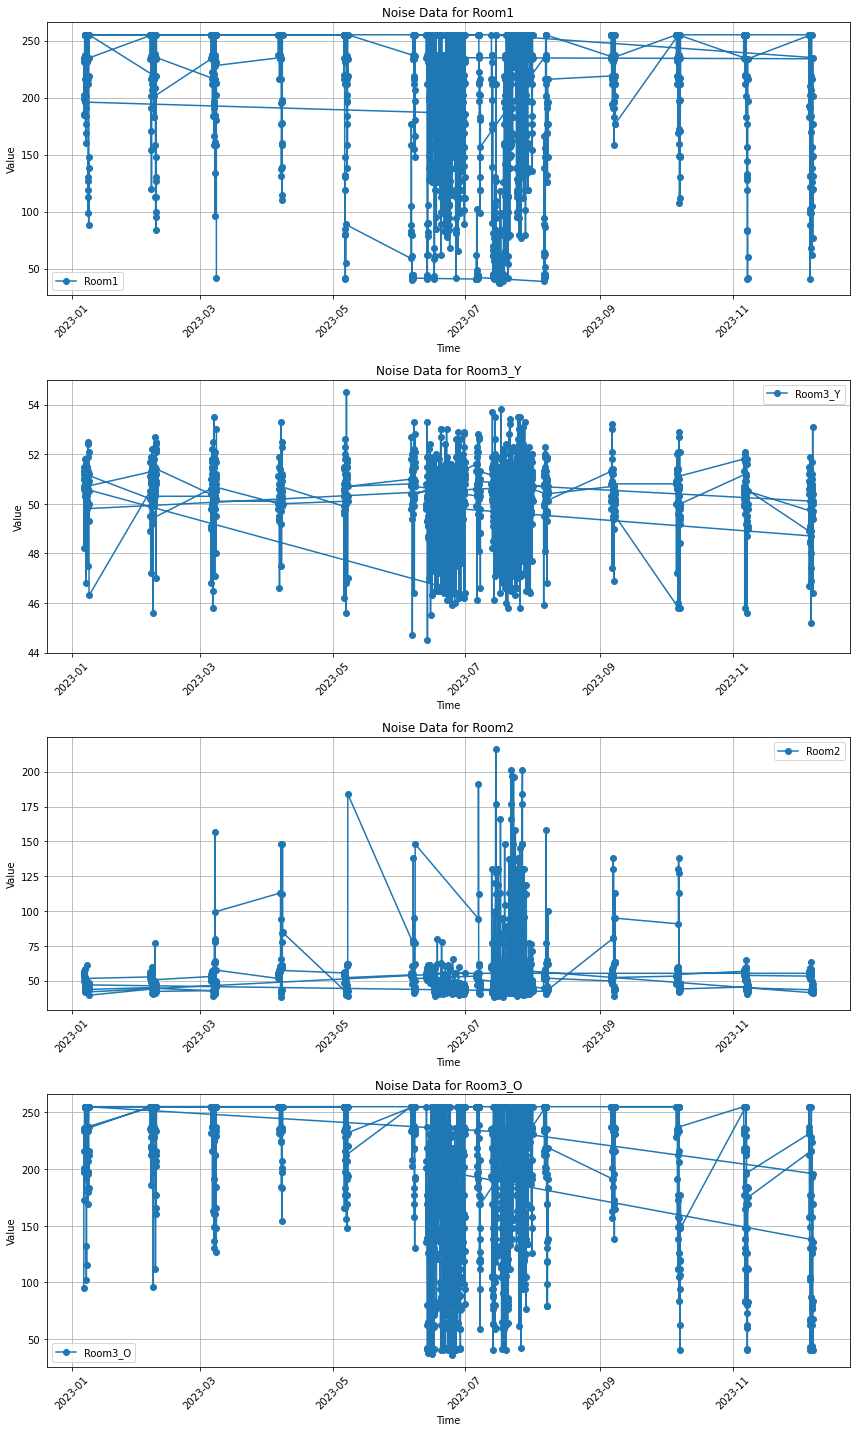